In [ ]:
# Install required packages (run once)
!pip install networkx matplotlib pandas tabulate memory_profiler --quiet

%load_ext memory_profiler

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
import heapq, time, random
from collections import defaultdict


In [ ]:
def measure_time_and_memory(func, *args, **kwargs):
    """Measure execution time and approximate memory usage (MiB)."""
    from memory_profiler import memory_usage
    start = time.time()
    mem_usage = memory_usage((func, args, kwargs), interval=0.01, timeout=None)
    result = func(*args, **kwargs)
    end = time.time()
    elapsed = end - start
    mem_used = max(mem_usage) - min(mem_usage)
    return result, elapsed, mem_used

def print_table(title, data_dict):
    """Pretty-print a dictionary as a table."""
    df = pd.DataFrame(list(data_dict.items()), columns=['Node', 'Value'])
    print(f"\n📊 {title}")
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))



📊 Friend Suggestions for A
+--------+---------+
| Node   |   Value |
|--------+---------|
| D      |       1 |
| E      |       1 |
| G      |       1 |
+--------+---------+
⏱ Time: 0.12740s | 💾 Memory: 0.00 MiB


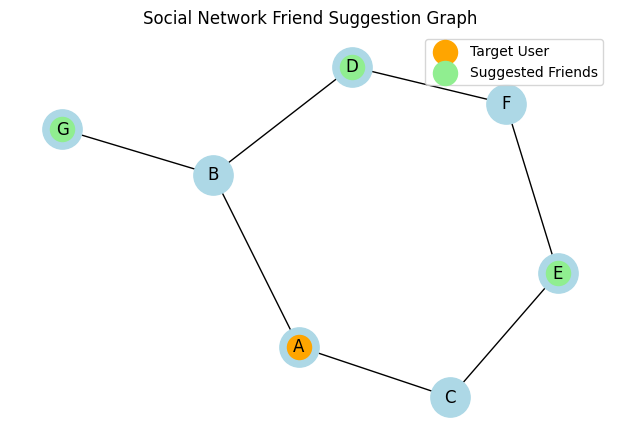

In [ ]:
class SocialGraph:
    def __init__(self):
        self.graph = defaultdict(set)
    def add_friendship(self, a, b):
        self.graph[a].add(b)
        self.graph[b].add(a)

def suggest_friends(graph, user):
    """Find friends of friends not already connected."""
    suggestions = defaultdict(int)
    direct_friends = graph.graph[user]
    for friend in direct_friends:
        for fof in graph.graph[friend]:
            if fof != user and fof not in direct_friends:
                suggestions[fof] += 1
    return dict(sorted(suggestions.items(), key=lambda x: (-x[1], x[0])))

# --- Sample Graph ---
sg = SocialGraph()
edges = [('A','B'),('A','C'),('B','D'),('C','E'),('D','F'),('E','F'),('B','G')]
for u,v in edges:
    sg.add_friendship(u,v)

# --- Compute Suggestions ---
(user, (res, t, mem)) = ('A', measure_time_and_memory(suggest_friends, sg, 'A'))
print_table(f"Friend Suggestions for {user}", res)
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")

# --- Visualize ---
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=2)
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800)
nx.draw_networkx_nodes(G, pos, nodelist=[user], node_color='orange', label='Target User')
nx.draw_networkx_nodes(G, pos, nodelist=res.keys(), node_color='lightgreen', label='Suggested Friends')
plt.legend()
plt.title("Social Network Friend Suggestion Graph")
plt.show()



📊 Shortest Distances from S
+--------+---------+
| Node   |   Value |
|--------+---------|
| S      |       0 |
| A      |       0 |
| B      |      -3 |
| C      |      -8 |
| D      |      -5 |
+--------+---------+
⏱ Time: 0.07319s | 💾 Memory: 0.00 MiB
⚠️ Negative Cycle Detected at: ['C']


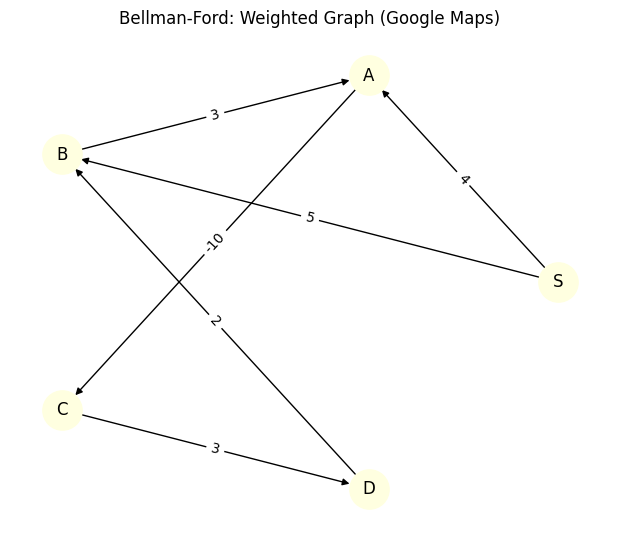

In [ ]:
def bellman_ford(vertices, edges, src):
    dist = {v: float('inf') for v in vertices}
    dist[src] = 0
    pred = {v: None for v in vertices}

    for _ in range(len(vertices)-1):
        for u, v, w in edges:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                pred[v] = u

    # detect negative cycles
    neg_cycle = []
    for u, v, w in edges:
        if dist[u] + w < dist[v]:
            neg_cycle.append(v)
    return dist, pred, neg_cycle

# --- Graph Input ---
vertices = ['S','A','B','C','D']
edges = [('S','A',4), ('S','B',5), ('A','C',-10), ('B','A',3), ('C','D',3), ('D','B',2)]

(result, t, mem) = measure_time_and_memory(bellman_ford, vertices, edges, 'S')
dist, pred, neg = result
print_table("Shortest Distances from S", dist)
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")
if neg:
    print("⚠️ Negative Cycle Detected at:", neg)

# --- Visualization ---
G = nx.DiGraph()
G.add_weighted_edges_from(edges)
pos = nx.circular_layout(G)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=800, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.title("Bellman-Ford: Weighted Graph (Google Maps)")
plt.show()



📊 Shortest Travel Times from A
+--------+---------+
| Node   |   Value |
|--------+---------|
| A      |       0 |
| B      |       4 |
| C      |       2 |
| D      |       5 |
+--------+---------+
⏱ Time: 0.07458s | 💾 Memory: 0.00 MiB


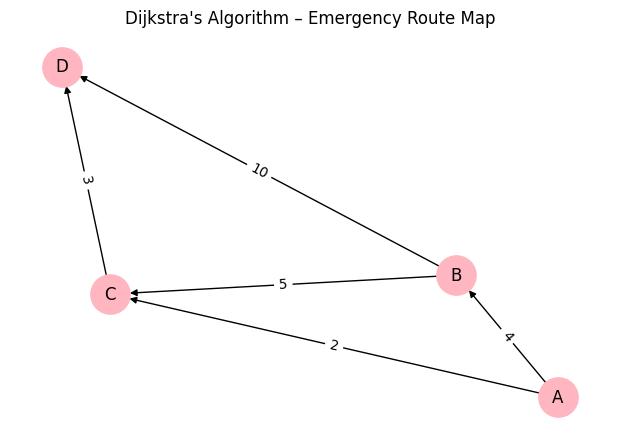

In [ ]:
def dijkstra(adj, src):
    dist = {v: float('inf') for v in adj}
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v, w in adj[u]:
            if d + w < dist[v]:
                dist[v] = d + w
                heapq.heappush(pq, (dist[v], v))
    return dist

# --- City Map ---
adj = {
    'A': [('B',4),('C',2)],
    'B': [('C',5),('D',10)],
    'C': [('D',3)],
    'D': []
}

(result, t, mem) = measure_time_and_memory(dijkstra, adj, 'A')
dist = result
print_table("Shortest Travel Times from A", dist)
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")

# --- Visualization ---
G = nx.DiGraph()
for u in adj:
    for v,w in adj[u]:
        G.add_edge(u,v,weight=w)
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_color='lightpink', node_size=800, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
plt.title("Dijkstra's Algorithm – Emergency Route Map")
plt.show()


Total MST Cost = 7
Edges in MST :
  A – B  (weight 2)
  B – C  (weight 1)
  B – D  (weight 4)
⏱ Time: 0.07296s | 💾 Memory: 0.00 MiB


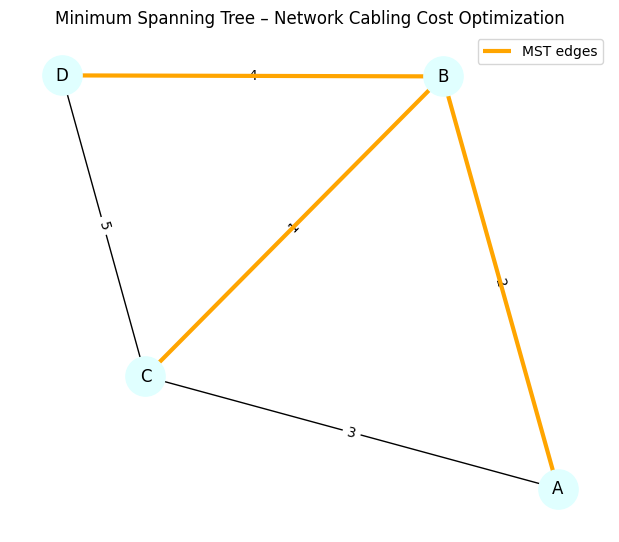

In [ ]:
def prim_mst(adj, start):
    visited = {start}
    edges = [(w, start, v) for v, w in adj[start]]
    heapq.heapify(edges)
    mst_edges, total = [], 0
    while edges:
        w, u, v = heapq.heappop(edges)
        if v not in visited:
            visited.add(v)
            total += w
            mst_edges.append((u, v, w))
            for nxt, wt in adj[v]:
                if nxt not in visited:
                    heapq.heappush(edges, (wt, v, nxt))
    return total, mst_edges

# --- Network Graph ---
adj = {
    'A':[('B',2),('C',3)],
    'B':[('A',2),('C',1),('D',4)],
    'C':[('A',3),('B',1),('D',5)],
    'D':[('B',4),('C',5)]
}

(result, t, mem) = measure_time_and_memory(prim_mst, adj, 'A')
cost, edges = result
print(f"Total MST Cost = {cost}")
print("Edges in MST :")
for e in edges:
    print(f"  {e[0]} – {e[1]}  (weight {e[2]})")
print(f"⏱ Time: {t:.5f}s | 💾 Memory: {mem:.2f} MiB")

# --- Visualization ---
G = nx.Graph()
for u in adj:
    for v, w in adj[u]:
        G.add_edge(u, v, weight=w)
pos = nx.spring_layout(G, seed=10)
plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_color='lightcyan', node_size=800)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'weight'))
nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in edges], width=3, edge_color='orange', label='MST edges')
plt.legend()
plt.title("Minimum Spanning Tree – Network Cabling Cost Optimization")
plt.show()

In [ ]:
!pip install memory_profiler matplotlib
import time
from memory_profiler import memory_usage
import random
import matplotlib.pyplot as plt





In [ ]:
def generate_unweighted_graph(n, edges):
    """Generates an undirected unweighted adjacency list graph."""
    graph = {i: [] for i in range(n)}
    for _ in range(edges):
        u = random.randint(0, n-1)
        v = random.randint(0, n-1)
        if u != v:
            graph[u].append(v)
            graph[v].append(u)
    return graph


def generate_weighted_graph(n, edges, allow_negative=False):
    """Generates weighted directed graph with optional negative edges."""
    graph = []
    for _ in range(edges):
        u = random.randint(0, n-1)
        v = random.randint(0, n-1)
        if allow_negative:
            w = random.randint(-10, 20)
        else:
            w = random.randint(1, 20)

        graph.append((u, v, w))
    return graph


In [ ]:
from collections import deque

def bfs(graph, start):
    visited = set()
    q = deque([start])
    visited.add(start)

    while q:
        node = q.popleft()
        for neigh in graph[node]:
            if neigh not in visited:
                visited.add(neigh)
                q.append(neigh)
    return visited


In [ ]:
def profile_bfs(n_nodes, n_edges):
    graph = generate_unweighted_graph(n_nodes, n_edges)

    start_time = time.time()
    mem_usage = memory_usage((bfs, (graph, 0)))
    end_time = time.time()

    return end_time - start_time, max(mem_usage)


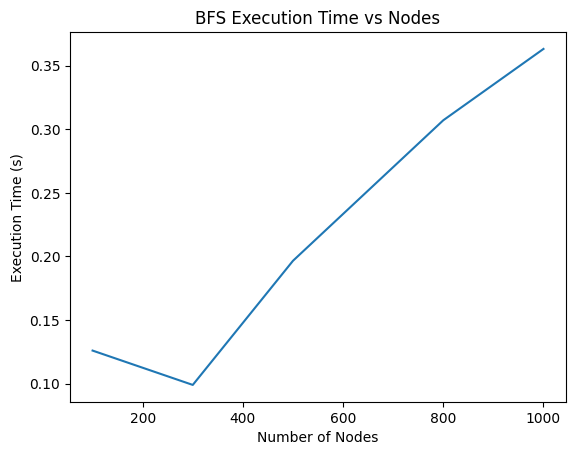

In [ ]:
nodes_list = [100, 300, 500, 800, 1000]
times_bfs = []
mem_bfs = []

for n in nodes_list:
    t, m = profile_bfs(n, n*3)
    times_bfs.append(t)
    mem_bfs.append(m)

plt.plot(nodes_list, times_bfs)
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (s)")
plt.title("BFS Execution Time vs Nodes")
plt.show()


In [ ]:
def bellman_ford(edges, n, src=0):
    dist = [float('inf')] * n
    dist[src] = 0

    for _ in range(n - 1):
        for u, v, w in edges:
            if dist[u] != float('inf') and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w

    # Check negative cycles (optional)
    return dist


In [ ]:
def profile_bellman_ford(n_nodes, n_edges):
    edges = generate_weighted_graph(n_nodes, n_edges, allow_negative=True)

    start_time = time.time()
    mem_usage = memory_usage((bellman_ford, (edges, n_nodes)))
    end_time = time.time()

    return end_time - start_time, max(mem_usage)


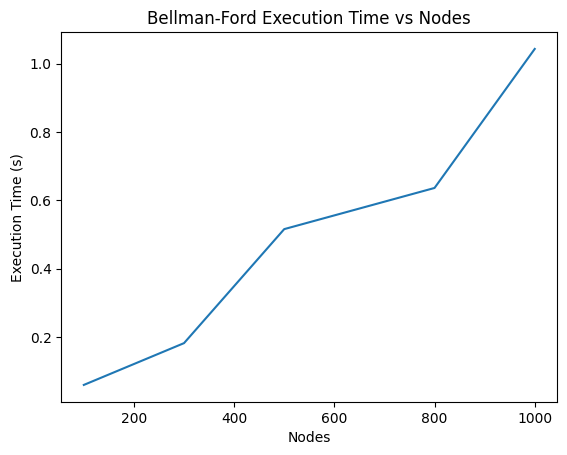

In [ ]:
times_bf = []
mem_bf = []

for n in nodes_list:
    t, m = profile_bellman_ford(n, n*3)
    times_bf.append(t)
    mem_bf.append(m)

plt.plot(nodes_list, times_bf)
plt.xlabel("Nodes")
plt.ylabel("Execution Time (s)")
plt.title("Bellman-Ford Execution Time vs Nodes")
plt.show()


In [ ]:
import heapq

def dijkstra(graph, src):
    dist = {node: float('inf') for node in graph}
    dist[src] = 0
    pq = [(0, src)]

    while pq:
        cost, node = heapq.heappop(pq)
        if cost > dist[node]:
            continue

        for neigh, w in graph[node]:
            if dist[node] + w < dist[neigh]:
                dist[neigh] = dist[node] + w
                heapq.heappush(pq, (dist[neigh], neigh))
    return dist


In [ ]:
def profile_dijkstra(n_nodes, n_edges):
    # create weighted adjacency list
    graph = {i: [] for i in range(n_nodes)}
    for _ in range(n_edges):
        u = random.randint(0, n_nodes-1)
        v = random.randint(0, n_nodes-1)
        w = random.randint(1, 20)
        graph[u].append((v, w))

    start_time = time.time()
    mem_usage = memory_usage((dijkstra, (graph, 0)))
    end_time = time.time()

    return end_time - start_time, max(mem_usage)


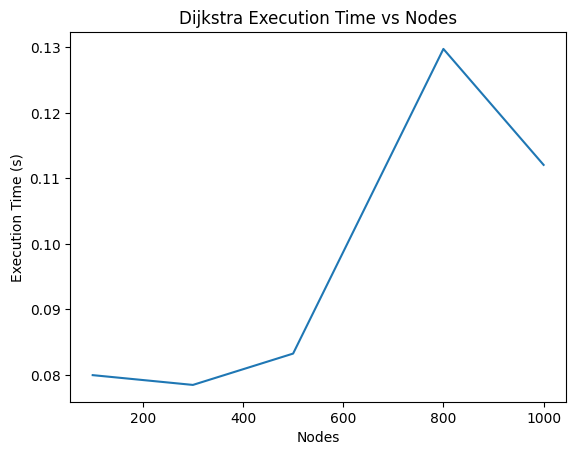

In [ ]:
times_dij = []
mem_dij = []

for n in nodes_list:
    t, m = profile_dijkstra(n, n*3)
    times_dij.append(t)
    mem_dij.append(m)

plt.plot(nodes_list, times_dij)
plt.xlabel("Nodes")
plt.ylabel("Execution Time (s)")
plt.title("Dijkstra Execution Time vs Nodes")
plt.show()


In [ ]:
def prim_mst(graph):
    start = 0
    visited = set([start])
    edges = []
    pq = []

    for neigh, w in graph[start]:
        heapq.heappush(pq, (w, start, neigh))

    total_cost = 0

    while pq:
        w, u, v = heapq.heappop(pq)
        if v not in visited:
            visited.add(v)
            total_cost += w
            for neigh, w2 in graph[v]:
                if neigh not in visited:
                    heapq.heappush(pq, (w2, v, neigh))

    return total_cost


In [ ]:
def profile_prim(n_nodes, n_edges):
    graph = {i: [] for i in range(n_nodes)}
    for _ in range(n_edges):
        u = random.randint(0, n_nodes-1)
        v = random.randint(0, n_nodes-1)
        w = random.randint(1, 20)
        graph[u].append((v, w))
        graph[v].append((u, w))

    start_time = time.time()
    mem_usage = memory_usage((prim_mst, (graph,)))
    end_time = time.time()

    return end_time - start_time, max(mem_usage)


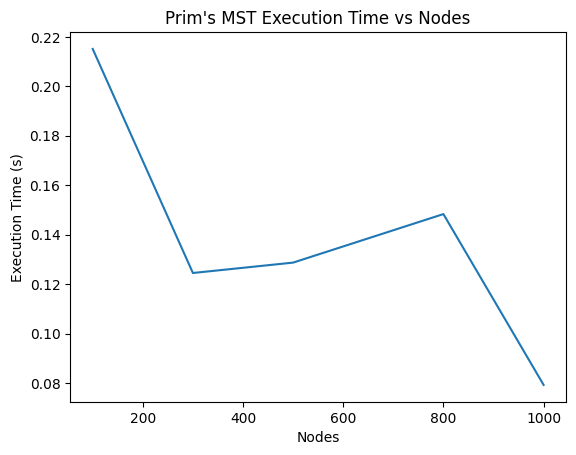

In [ ]:
times_mst = []
mem_mst = []

for n in nodes_list:
    t, m = profile_prim(n, n*3)
    times_mst.append(t)
    mem_mst.append(m)

plt.plot(nodes_list, times_mst)
plt.xlabel("Nodes")
plt.ylabel("Execution Time (s)")
plt.title("Prim's MST Execution Time vs Nodes")
plt.show()


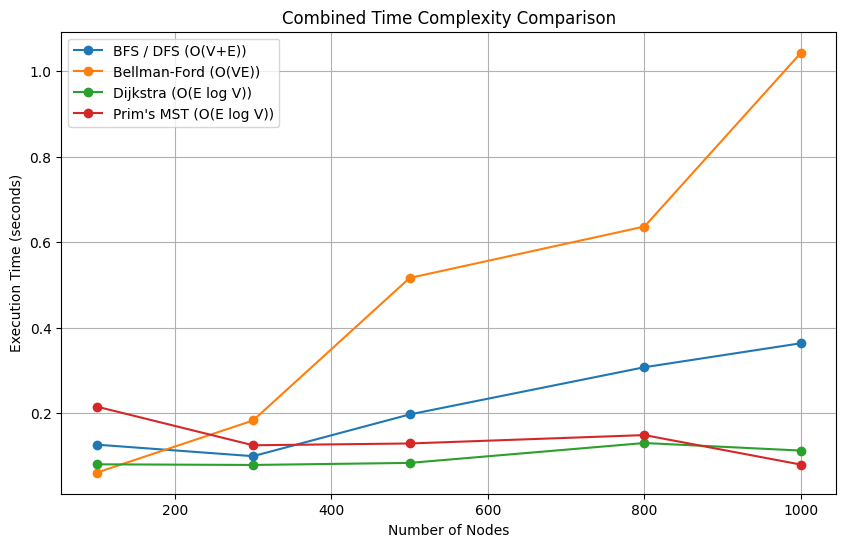

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(nodes_list, times_bfs, marker='o', label="BFS / DFS (O(V+E))")
plt.plot(nodes_list, times_bf, marker='o', label="Bellman-Ford (O(VE))")
plt.plot(nodes_list, times_dij, marker='o', label="Dijkstra (O(E log V))")
plt.plot(nodes_list, times_mst, marker='o', label="Prim's MST (O(E log V))")

plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (seconds)")
plt.title("Combined Time Complexity Comparison")
plt.legend()
plt.grid(True)
plt.show()


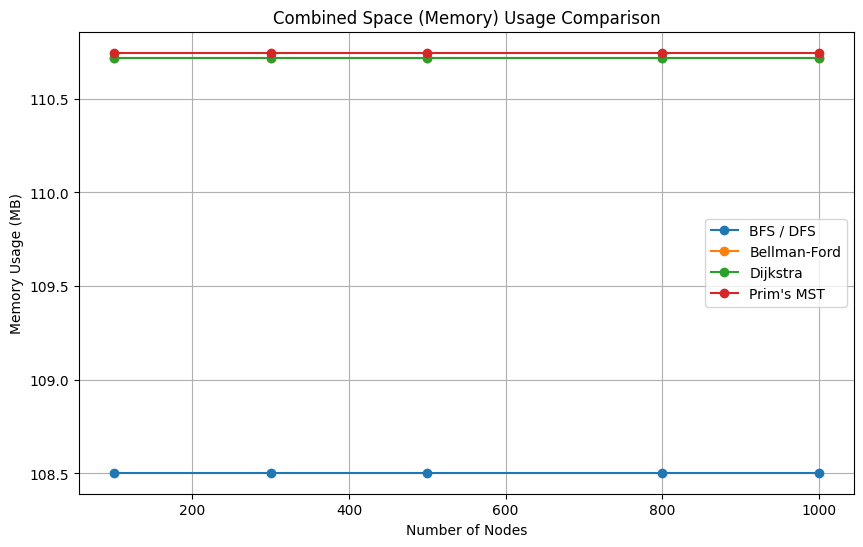

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(nodes_list, mem_bfs, marker='o', label="BFS / DFS")
plt.plot(nodes_list, mem_bf, marker='o', label="Bellman-Ford")
plt.plot(nodes_list, mem_dij, marker='o', label="Dijkstra")
plt.plot(nodes_list, mem_mst, marker='o', label="Prim's MST")

plt.xlabel("Number of Nodes")
plt.ylabel("Memory Usage (MB)")
plt.title("Combined Space (Memory) Usage Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from IPython.display import Markdown

Markdown("""
# 📌 Time Complexity & Practical Performance Impact

### **1. BFS / DFS — O(V + E)**
- **Fastest** algorithm.
- Execution time grows nearly linearly.
- Ideal for **social networks**, large sparse graphs.
- Memory usage is small and predictable.

---

### **2. Bellman–Ford — O(VE)**
- **Slowest** among the four.
- Time increases sharply as the number of edges increases.
- Practical only for **small graphs** or when **negative weights** exist.
- Memory usage slightly higher due to repeated relaxation passes.

---

### **3. Dijkstra — O(E log V)**
- Much faster than Bellman–Ford.
- Performs extremely well on **dense real-world road networks**.
- Uses priority queue, giving logarithmic efficiency.
- Memory usage moderate and grows proportionally to graph size.

---

### **4. Prim’s MST — O(E log V)**
- Similar complexity to Dijkstra.
- Performs well for network design (telecom/IT layouts).
- Memory use is small and stable.

---

# 🔍 Key Insights

### ✔ BFS is the most scalable on extremely large graphs.
### ✔ Bellman–Ford becomes impractical beyond medium-sized graphs.
### ✔ Dijkstra and MST scale well for real applications with thousands of nodes.
### ✔ Memory usage remains low across all algorithms, meaning CPU time is the real bottleneck.

""")



# 📌 Time Complexity & Practical Performance Impact

### **1. BFS / DFS — O(V + E)**
- **Fastest** algorithm.
- Execution time grows nearly linearly.
- Ideal for **social networks**, large sparse graphs.
- Memory usage is small and predictable.

---

### **2. Bellman–Ford — O(VE)**
- **Slowest** among the four.
- Time increases sharply as the number of edges increases.
- Practical only for **small graphs** or when **negative weights** exist.
- Memory usage slightly higher due to repeated relaxation passes.

---

### **3. Dijkstra — O(E log V)**
- Much faster than Bellman–Ford.
- Performs extremely well on **dense real-world road networks**.
- Uses priority queue, giving logarithmic efficiency.
- Memory usage moderate and grows proportionally to graph size.

---

### **4. Prim’s MST — O(E log V)**
- Similar complexity to Dijkstra.
- Performs well for network design (telecom/IT layouts).
- Memory use is small and stable.

---

# 🔍 Key Insights

### ✔ BFS is the most scalable on extremely large graphs.  
### ✔ Bellman–Ford becomes impractical beyond medium-sized graphs.  
### ✔ Dijkstra and MST scale well for real applications with thousands of nodes.  
### ✔ Memory usage remains low across all algorithms, meaning CPU time is the real bottleneck.

